# Store Sales Time Series Forecasting

## Business Context 

Using 4 years of sales data from a store in the US, we want to create a model that will allow us to forecast future sales. 

## Business Question

What are the forecasted sales from 2018-01-02 until 2018-01-31?

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

In [12]:
df = pd.read_csv("train.csv")

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [14]:
# Handle missing values 
df['Postal Code'].fillna(df['Postal Code'].mode()[0], inplace=True)

In [15]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9800 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [16]:
df.head(8)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680
5,6,CA-2015-115812,09/06/2015,14/06/2015,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032.0,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600
6,7,CA-2015-115812,09/06/2015,14/06/2015,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032.0,West,OFF-AR-10002833,Office Supplies,Art,Newell 322,7.2800
7,8,CA-2015-115812,09/06/2015,14/06/2015,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032.0,West,TEC-PH-10002275,Technology,Phones,Mitel 5320 IP Phone VoIP phone,907.1520


In [17]:
def clean_data(data):
    # Convert Order Date
    df['Order Date'] = pd.to_datetime(df['Order Date'], format="%d/%m/%Y")
    
    # Create Day of Week 
    df['Day of Week'] = df['Order Date'].dt.dayofweek
    
    # Create Day
    df['Day'] = df['Order Date'].dt.day
    
    # Create Year
    df['Year'] = df['Order Date'].dt.year
    
    # Creaate Month
    df['Month'] = df['Order Date'].dt.month
    
    # Create Season 
    df['Season'] = df['Order Date'].apply(lambda x: "Spring" if x.month in [3, 4, 5] else
                                    "Summer" if x.month in [6, 7, 8] else
                                    "Autumn" if x.month in [9, 10, 11] else
                                    "Winter")
    
    # Convert Postal Code to int
    df['Postal Code'] = df['Postal Code'].astype(int)
    
    # Drop rows
    df.drop(['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 
         'Country', 'City', 'State', 'Postal Code', 'Product ID', 
         'Product Name'], axis=1, inplace=True)
    
    return df

clean_data(df)

,Order Date,Segment,Region,Category,Sub-Category,Sales,Day of Week,Day,Year,Month,Season
0,2017-11-08,Consumer,South,Furniture,Bookcases,261.9600,2,8,2017,11,Autumn
1,2017-11-08,Consumer,South,Furniture,Chairs,731.9400,2,8,2017,11,Autumn
2,2017-06-12,Corporate,West,Office Supplies,Labels,14.6200,0,12,2017,6,Summer
3,2016-10-11,Consumer,South,Furniture,Tables,957.5775,1,11,2016,10,Autumn
4,2016-10-11,Consumer,South,Office Supplies,Storage,22.3680,1,11,2016,10,Autumn
...,...,...,...,...,...,...,...,...,...,...,...
9795,2017-05-21,Corporate,Central,Office Supplies,Binders,3.7980,6,21,2017,5,Spring
9796,2016-01-12,Corporate,East,Office Supplies,Art,10.3680,1,12,2016,1,Winter
9797,2016-01-12,Corporate,East,Technology,Phones,235.1880,1,12,2016,1,Winter
9798,2016-01-12,Corporate,East,Technology,Phones,26.3760,1,12,2016,1,Winter


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Order Date    9800 non-null   datetime64[ns]
 1   Segment       9800 non-null   object        
 2   Region        9800 non-null   object        
 3   Category      9800 non-null   object        
 4   Sub-Category  9800 non-null   object        
 5   Sales         9800 non-null   float64       
 6   Day of Week   9800 non-null   int32         
 7   Day           9800 non-null   int32         
 8   Year          9800 non-null   int32         
 9   Month         9800 non-null   int32         
 10  Season        9800 non-null   object        
dtypes: datetime64[ns](1), float64(1), int32(4), object(5)
memory usage: 689.2+ KB


In [21]:
df['Category'].value_counts()

Category
Office Supplies    5909
Furniture          2078
Technology         1813
Name: count, dtype: int64

In [20]:
def custom_df_summary(data):
    # Create an empty DataFrame to store the summary
    summary = pd.DataFrame(index=df.columns)
    cat_cols = data.select_dtypes(include=[np.datetime64, np.object_]).columns
    data2 = data.drop(cat_cols, axis=1)
    
    # Calculate required statistics
    summary['Non-Null Count'] = data2.notnull().sum()
    summary['Unique Values'] = data2.nunique()
    summary['% Missing Values'] = data2.isnull().mean() * 100
    summary['Skewness'] = data2.skew()
    summary['Kurtosis'] = data2.kurtosis()
    
    # Display the summary
    return pd.DataFrame(summary)

summary = custom_df_summary(df)
summary

,Non-Null Count,Unique Values,% Missing Values,Skewness,Kurtosis
Order Date,NaN,NaN,NaN,NaN,NaN
Segment,NaN,NaN,NaN,NaN,NaN
Region,NaN,NaN,NaN,NaN,NaN
Category,NaN,NaN,NaN,NaN,NaN
Sub-Category,NaN,NaN,NaN,NaN,NaN
Sales,9800.0,5757.0,0.0,12.983483,304.445088
Day of Week,9800.0,7.0,0.0,0.026115,-1.521498
Day,9800.0,31.0,0.0,0.015648,-1.179980
Year,9800.0,4.0,0.0,-0.285519,-1.307272
Month,9800.0,12.0,0.0,-0.431988,-0.991166


In [26]:
grouped_df = df.groupby(by='Order Date')['Sales'].sum().reset_index()

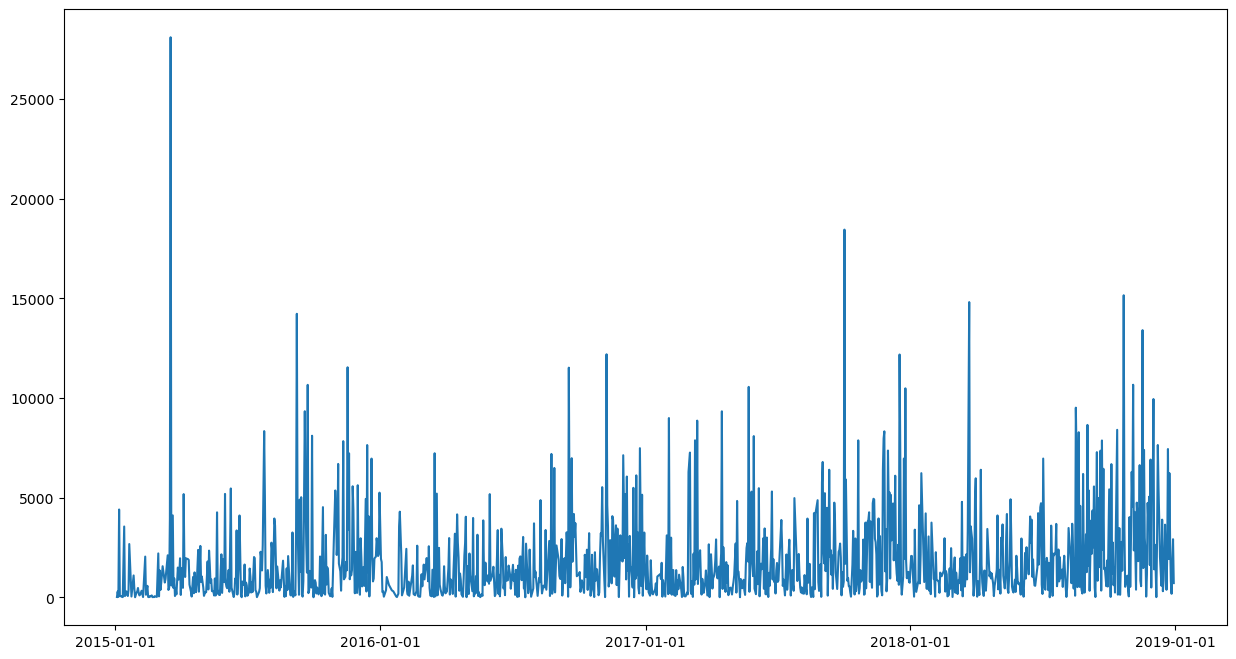

In [27]:
plt.figure(figsize=(15, 8))

plt.plot(grouped_df['Order Date'], grouped_df['Sales'])
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-01-01'))

plt.show()


In [28]:
# Check for stationarity 

from statsmodels.tsa.stattools import adfuller

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data is stationary")
    else:
        print("Weak evidence against null hypothesis, fail to reject the null hypothesis. Data is non-stationary ")

adfuller_test(grouped_df['Sales'])


ADF Test Statistic : -5.761112092918505
p-value : 5.669526815779303e-07
#Lags Used : 14
Number of Observations : 1215
Strong evidence against the null hypothesis, reject the null hypothesis. Data is stationary


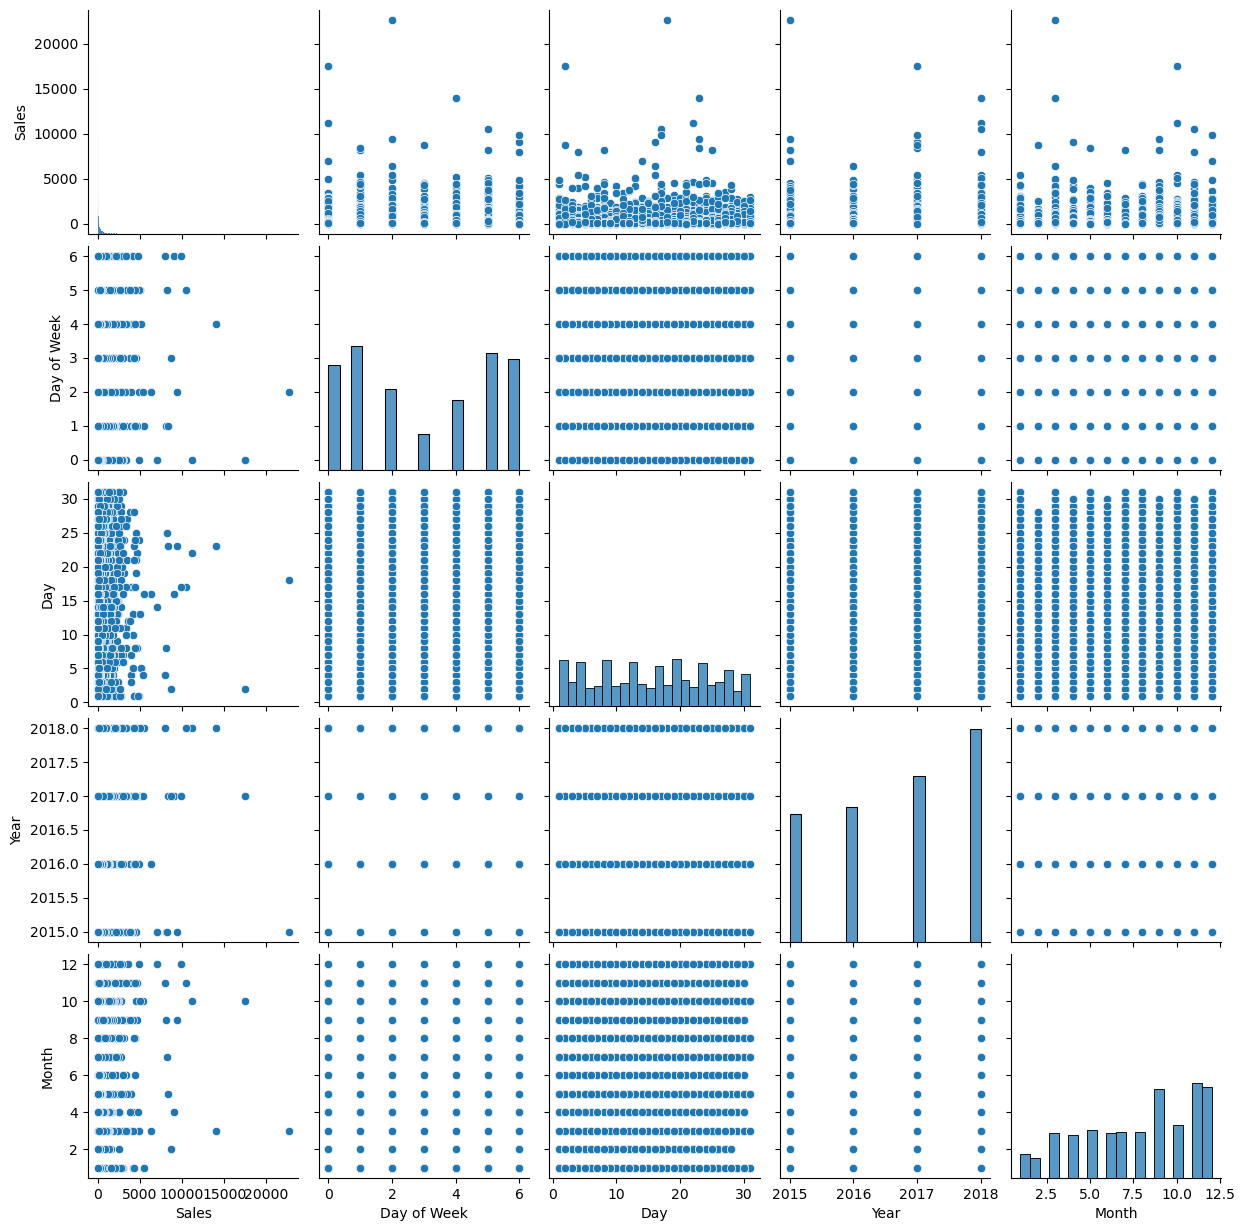

In [26]:
sns.pairplot(df)

In [28]:
df.to_csv("store_sales_data_clean_20240214.csv")

In [13]:
df.head()

,Order Date,Segment,Region,Category,Sub-Category,Sales,Day of Week,Day,Year,Month,Season
0,2017-11-08,Consumer,South,Furniture,Bookcases,261.9600,2,8,2017,11,Autumn
1,2017-11-08,Consumer,South,Furniture,Chairs,731.9400,2,8,2017,11,Autumn
2,2017-06-12,Corporate,West,Office Supplies,Labels,14.6200,0,12,2017,6,Summer
3,2016-10-11,Consumer,South,Furniture,Tables,957.5775,1,11,2016,10,Autumn
4,2016-10-11,Consumer,South,Office Supplies,Storage,22.3680,1,11,2016,10,Autumn


In [29]:
# Set the date as the index and order by date
df.set_index('Order Date', inplace=True)
df.sort_index(inplace=True)

df.head()

,Segment,Region,Category,Sub-Category,Sales,Day of Week,Day,Year,Month,Season
Order Date,,,,,,,,,,
2015-01-03,Consumer,Central,Office Supplies,Paper,16.448,5,3,2015,1,Winter
2015-01-04,Home Office,Central,Office Supplies,Binders,3.540,6,4,2015,1,Winter
2015-01-04,Home Office,Central,Office Supplies,Storage,272.736,6,4,2015,1,Winter
2015-01-04,Home Office,Central,Office Supplies,Labels,11.784,6,4,2015,1,Winter
2015-01-05,Consumer,East,Office Supplies,Art,19.536,0,5,2015,1,Winter


In [38]:
# Show sales from January
print("Jan 2015 Sales: ", df['2015-01-01':'2015-01-31']['Sales'].sum())
print("Jan 2016 Sales: ", df['2016-01-01':'2016-01-31']['Sales'].sum())
print("Jan 2017 Sales: ", df['2017-01-01':'2017-01-31']['Sales'].sum())
print("Jan 2018 Sales: ", df['2018-01-01':'2018-01-31']['Sales'].sum())

Jan 2015 Sales:  14205.707
Jan 2016 Sales:  18066.9576
Jan 2017 Sales:  18542.490999999998
Jan 2018 Sales:  43476.474
